In [28]:
from math import sqrt
import pde
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from dateutil import parser
import numpy as np
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid
from IPython.display import HTML
from celluloid import Camera
from pde import DiffusionPDE, ScalarField, UnitGrid
from GPy.models import GPRegression
import GPy
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction
from emukit.core import ContinuousParameter, ParameterSpace
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import itertools
from emukit.core.acquisition.acquisition_per_cost import acquisition_per_expected_cost
from emukit.core.interfaces.models import IModel
from sklearn.linear_model import LinearRegression


In [10]:
def get_PDE(param):
    if param["pde_name"] == "diffusion":
        grid = UnitGrid([64, 64])  # generate grid
        state = ScalarField.random_uniform(grid, 0.2, 0.3,rng=np.random.default_rng(seed=param["seed"]))  # generate initial condition
        eq = DiffusionPDE(diffusivity=param["diffusivity"])  # define the pde
        #state.plot(title='Initial state')
    elif param["pde_name"] == "brusselator":
        a, b = 1, 3 # 1, 3
        d0, d1 = param["diffusivity"], 0.1
        eq = PDE(
            {
                "u": f"{d0} * laplace(u) + {a} - ({b} + 1) * u + u**2 * v",
                "v": f"{d1} * laplace(v) + {b} * u - u**2 * v",
            }
        )

        # initialize state
        grid = UnitGrid([64, 64])
        u = ScalarField(grid, a, label="Field $u$")
        v = b / a + 0.1 * ScalarField.random_normal(grid, label="Field $v$",rng=np.random.default_rng(seed=param["seed"]))
        state = FieldCollection([u, v])
        #state.plot(title='Initial state')
    else:
        raise("Error")
    return eq,state

def run_PDE(param,plot_sol=False,store_video=False):
    eq,state = get_PDE(param)
    solver = pde.ExplicitSolver(eq)
    storage = MemoryStorage()
    controller1 = pde.Controller(solver, t_range=param["t_range"], tracker=[storage.tracker(0.02)]) # 20
    print("Running solver with dt=",param["dt"])
    sol = controller1.run(state, dt=param["dt"])
    if len(sol.data.shape)>2: # If there are more than one dimension in the PDE select the given one according to param 
        sol = sol.data[param["dim_data"],:,:].flatten()
    else:
        sol = sol.data.flatten()
    if plot_sol:
        sol.plot()
    if store_video:
        pde.visualization.movie(storage=storage,filename="./../assets/"+param["pde_name"]+"/"+"baseline"+".mp4")
    return {"param":param,"sol":sol,"storage":storage,"time":float(controller1.diagnostics["controller"]["profiler"]["solver"])}
    

    



In [8]:
param = {"pde_name":"brusselator","diffusivity":1,"dt":1e-03,"t_range":10,"seed":100,"dim_data":1}


Running solver with dt= 0.001


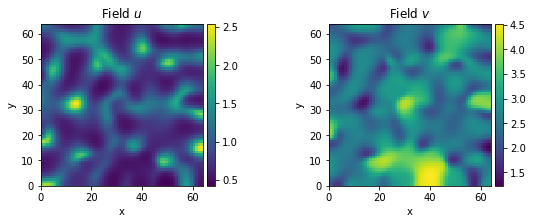

100%|██████████| 501/501 [01:37<00:00,  5.16it/s]


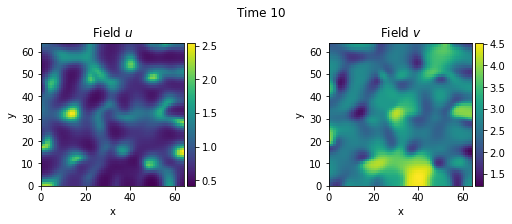

In [135]:
result = run_PDE(param,plot_sol=True,store_video=True)

In [11]:
f = lambda x: len(np.where(x > 4.25)[0])
X, Y = [],[]
cost = {}
param_list = [] 
dt_list = [1e-1,1e-2]
diff_list = np.linspace(0.1,1,2)
param_list = []

for dt,diff in itertools.product(dt_list,diff_list):
    param["dt"] = dt
    param["diff"] = diff
    param_list.append(param.copy())

result = list(map(run_PDE,param_list))

X = [[i["param"]["dt"],i["param"]["diff"]]for i in result]
Y = [f(i["sol"]) for i in result]
c = [i["time"] for i in result]

Running solver with dt= 0.1
Running solver with dt= 0.1
Running solver with dt= 0.01
Running solver with dt= 0.01


In [13]:
X = np.array(X)
X = StandardScaler().fit_transform(X)
Y = np.array(Y).reshape((-1,1))


In [14]:

fig = go.Figure(data=[go.Scatter3d(x=X[:,0],y=X[:,1],z=Y.reshape((-1)),mode="markers",marker_symbol="x",marker_size=5)])
fig.show()

In [15]:
kernel = GPy.kern.RBF(input_dim=2,ARD=True,lengthscale=[1,1],variance=1)
model_gpy = GPRegression(X,Y,kernel = kernel,normalizer=True,noise_var=0.05)
model_gpy.parameters[0].variance.fix()
model_gpy.parameters[1].variance.fix()
model_gpy.optimize()
print("Param: ",model_gpy.param_array)
print("Lengthscale: ",model_gpy.param_array[2])


Param:  [1.00000000e+00 2.40809499e-08 4.92413909e+01 5.00000000e-02]
Lengthscale:  49.24139089576485


In [32]:
mesh_size = 100
space = ParameterSpace([ContinuousParameter('diff', X[:,0].min(), X[:,0].max()),
                        ContinuousParameter('dt', X[:,1].min(), X[:,1].max())])
x_1_space = np.linspace(space.parameters[0].min,space.parameters[0].max,mesh_size)
x_2_space = np.linspace(space.parameters[1].min,space.parameters[1].max,mesh_size)
x_monte_carlo = np.vstack([x_1_space,np.ones((mesh_size))*space.parameters[1].min]).T
xx, yy = np.meshgrid(x_1_space,x_2_space)
X_mesh = np.hstack([xx.reshape((-1,1)),yy.reshape((-1,1))])


class CostModel(IModel):
    def __init__(self,X,c):
        self.clf = LinearRegression()
        self.clf.fit(X[:,0].reshape((-1,1)),c)
    def predict(self, X: np.ndarray):
        w = self.clf.predict(X[:,0].reshape((-1,1))).reshape((-1,1))
        return (w,X)

cost_model = CostModel(X,c)

model_emukit = GPyModelWrapper(model_gpy)
model_variance = IntegratedVarianceReduction(model=model_emukit,space=space,x_monte_carlo=x_monte_carlo)
weighted_variance = acquisition_per_expected_cost(model_variance,cost_model)

utility = model_variance.evaluate(X_mesh).reshape((yy.shape))
weighted_utility = weighted_variance.evaluate(X_mesh).reshape((yy.shape))



In [33]:

fig = go.Figure(data=[go.Surface(x=xx,y=yy,z=utility, opacity=0.7, showscale=False),
    go.Scatter3d(x=X[:,0],y=X[:,1],z=[utility.min()]*X.shape[0],mode="markers",marker_symbol="x",marker_size=5)])
fig.show()

fig = go.Figure(data=[go.Surface(x=xx,y=yy,z=weighted_utility, opacity=0.7, showscale=False),
    go.Scatter3d(x=X[:,0],y=X[:,1],z=[utility.min()]*X.shape[0],mode="markers",marker_symbol="x",marker_size=5)])
fig.show()